# Geostrophic Method

Example of geostrophic velocity calculation from CTD profiles collect during the SAM03 cruise of the "South Atlantic Meridional Overturning Circulation" (SAMOC) project.

In [1]:
# basic python modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# utility functions for dealing with Seabird CTD data 
from Utils import *

# nice colomaps for oceanography
import cmocean

# Gibbs seawater toolbox
import gsw

/Users/crocha/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Get SAM03 SAMOC CTD section
This uses the Get_CTD_Section function, which is abstracted away in Utils.py, to load the .cnv data, concatenate the profiles and put them into an xarray DataArray for easy manipulation.

In [3]:
datapath = '../Data/'
stations = ['4','5','6','7','8','9'] 

ctdsection = Get_CTD_Section(datapath,stations)

ctdsection

<xarray.Dataset>
Dimensions:      (cast: 6, pressure: 4844)
Coordinates:
  * pressure     (pressure) float64 1.0 2.0 3.0 ... 4.843e+03 4.844e+03
  * cast         (cast) int64 0 1 2 3 4 5
    latitude     (cast) float64 -34.5 -34.5 -34.51 -34.5 -34.48 -34.52
    longitude    (cast) float64 -51.5 -50.5 -49.48 -48.49 -47.49 -44.43
    station      (cast) <U1 '4' '5' '6' '7' '8' '9'
    distance     (cast) float64 0.0 91.35 185.2 275.1 366.9 647.5
Data variables:
    temperature  (pressure, cast) float64 15.56 19.52 18.96 ... nan nan 0.2382
    salinity     (pressure, cast) float64 29.56 29.92 36.2 ... nan nan 34.67

# Potential density

In [4]:
# Calculate potential density and put it into the DataArray
da = xr.apply_ufunc(gsw.density.sigma0, ctdsection['salinity'],ctdsection['temperature'], 
                    output_dtypes=[ctdsection['salinity'].dtype])

sigma0 = da.compute()
sigma0.name = r'sigma0'
sigma0.attrs["units"] = r"$kg/m^3$"

ctdsection = xr.merge([ctdsection,sigma0])

# T-S diagram

In [5]:
ctdsection['salinity'].size, ctdsection['sigma0'].values.size

(29064, 29064)

(32.5, 36.5)

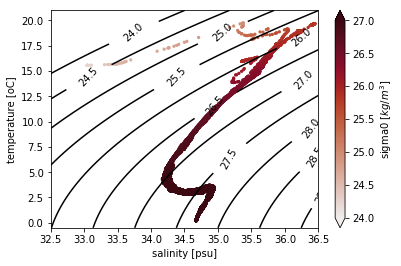

In [6]:
# scatter plot of all TS data

kwargs = {'s' : 5, 'cmap' : cmocean.cm.amp, 'vmin' : 24, 'vmax' : 27}
psc = ctdsection.plot.scatter('salinity','temperature','sigma0',**kwargs)

# plot lines of constant density
s, t = np.linspace(32,37), np.linspace(-0.5,21)
S, T = np.meshgrid(s,t)
SIG0 = gsw.density.sigma0(S,T)
csig0 = np.arange(24,30,0.5)
cs = plt.contour(S,T,SIG0,levels=csig0,colors='k')
plt.clabel(cs, csig0,fmt='%1.1f')

plt.xlim(32.5,36.5)

# Hydrographic section

In [7]:
def plot_stations(ax,zmin,station_type='ctd'):
    if station_type == 'ctd': 
        ax.plot(ctdsection['distance'].values,[0]*len(ctdsection['distance'].values),
             'kv',markersize=13)
    plt.ylim(zmin,0)
    plt.xlim(-15,ctdsection['distance'].values.max()+15)
        
# full depth
def plot_hydrographic_sections(zmin=4500):
    fig = plt.figure(figsize=(17,5))

    ax = fig.add_subplot(131)
    kwargs = {'levels' : np.linspace(0,20,10),'cmap': cmocean.cm.amp}
    ctdsection['temperature'].plot.contourf('distance','pressure',**kwargs)
    plot_stations(ax,zmin)

    fig.subplots_adjust(wspace=0.6)

    ax = fig.add_subplot(132)
    kwargs = {'levels' : np.linspace(34,36.5,10)}
    ctdsection['salinity'].plot.contourf('distance','pressure',**kwargs)
    plt.ylim(zmin,0)
    plot_stations(ax,zmin)

    ax = fig.add_subplot(133)
    kwargs = {'levels' : np.linspace(24,27.5,10),'cmap': cmocean.cm.dense}
    ctdsection['sigma0'].plot.contourf('distance','pressure',**kwargs)
    plt.ylim(zmin,0)
    plot_stations(ax,zmin)

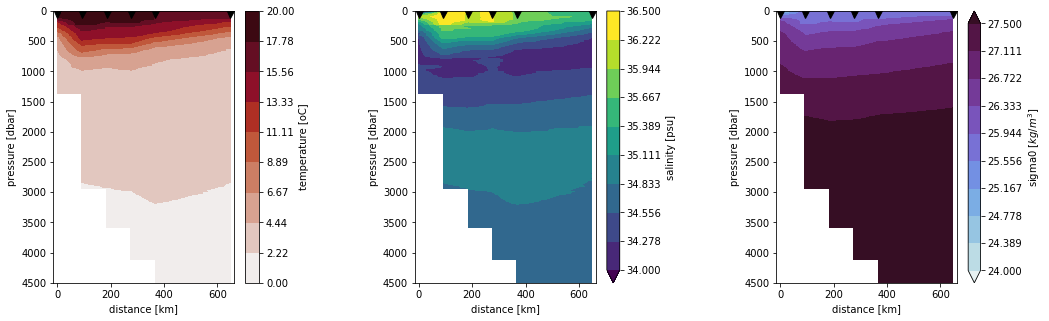

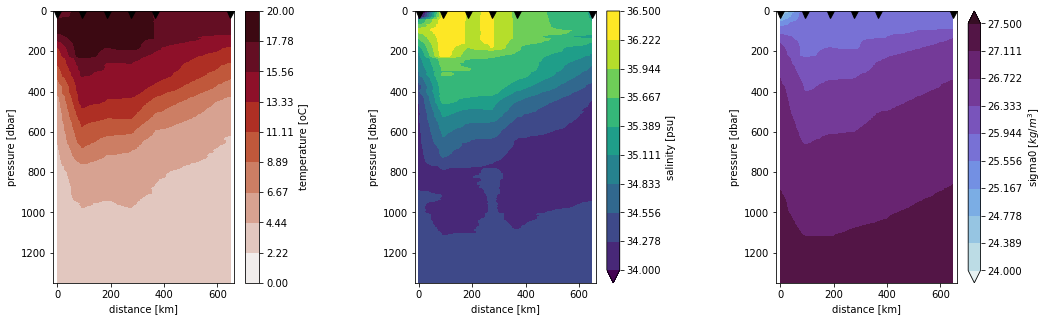

In [8]:
# full water column
plot_hydrographic_sections(zmin=4500)

# upper 1350 m
plot_hydrographic_sections(zmin=1350)

# Calculate geostrophic velocity relative to 1350 dbar

In [20]:
# First calculate the geopotential anomaly
dh = gsw.geo_strf_dyn_height(ctdsection['salinity'].values,ctdsection['temperature'].values, 
                    ctdsection['pressure'].values,p_ref=1350)

# Obs: the new version of gsw supports xarray DataArrays, but this is not working well with gsw.geostrohic_velocity(), 
#     thus I'm doing this lazily call of gsw methods with numpy arrays (.values).

In [16]:
# Then calculate the geostrophic velocity
vgeo,longitude_v,latitude_v = gsw.geostrophic_velocity(dh,ctdsection['longitude'].values, 
                                                       ctdsection['latitude'].values)

In [17]:
# The Position (in distance from shallowest station) of velocity estimate
# is mid-way between CTD stations
dist0 = 0.5*(ctdsection['distance'].values[:2].sum())
distance_v = np.cumsum(np.hstack([dist0,gsw.distance(longitude_v,latitude_v)/1e3]))

# Density and velocity sections

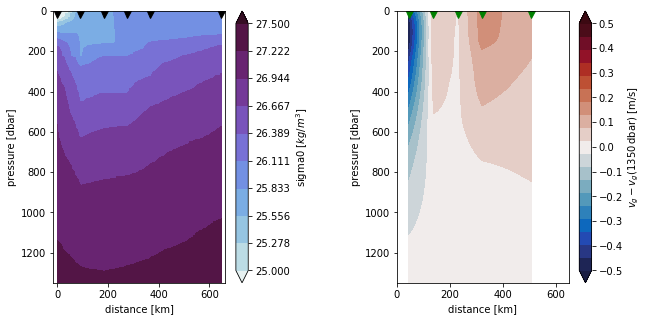

In [13]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
kwargs = {'levels' : np.linspace(25.,27.5,10), 'cmap': cmocean.cm.dense}
ctdsection['sigma0'].plot.contourf('distance','pressure',**kwargs)
plot_stations(ax,zmin=1350)

fig.subplots_adjust(wspace=0.6)

ax = fig.add_subplot(122)

kwargs = {'levels': np.linspace(-.5,.5,20), 'extend' :'both', 
          'cmap': cmocean.cm.balance}

plt.contourf(distance_v,ctdsection['pressure'].values,vgeo,**kwargs)
plt.ylim(1350,0)
plt.xlim(0,ctdsection['distance'].max())
plt.ylabel('pressure [dbar]')
plt.xlabel('distance [km]')
cb = plt.colorbar(ticks=np.arange(-5,.6,.1),label=r'$v_g-v_g(1350\,$dbar) [m/s]')

ax.plot(distance_v,[0]*len(distance_v),'gv',markersize=13)

# Dynamic height
Plot the dynamic height at the surface relative to 1350m. This is a very good approximation for the sea-surface height––note that the sea level changes by 30cm across the current.

Text(0, 0.5, 'Dynamic height [m]')

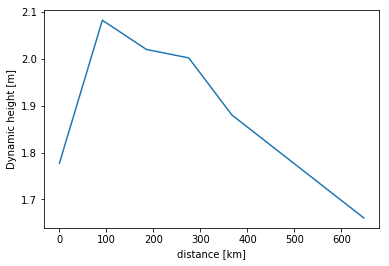

In [14]:
plt.plot(ctdsection['distance'].values,dh[0]/9.81)
plt.xlabel('distance [km]')
plt.ylabel('Dynamic height [m]')